In [2]:
import h5py

In [3]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf

2023-10-19 16:54:59.976927: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-19 16:54:59.981013: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 16:55:00.037135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 16:55:00.037204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 16:55:00.037260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [15]:
from tensorflow import *
from tensorflow.keras.models import Sequential

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.layers import Conv2D, MaxPooling2D,MaxPool2D, Dense , Dropout,Flatten, Activation

In [42]:
lr_init = 1.e-3
batch_size = 64
#epochs =20
doGPU = False
start =0
stop = 16000

In [25]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

2023-10-19 17:05:10.325514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-10-19 17:05:10.325559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: iyer-SS400TA-55
2023-10-19 17:05:10.325565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: iyer-SS400TA-55
2023-10-19 17:05:10.325760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.12
2023-10-19 17:05:10.325780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  535.104.12  Release Build  (dvs-builder@U16-I3-A14-4-4)  Wed Sep 20 09:32:00 UTC 2023
GCC version:  gcc version 11.4.0 (Ubuntu 11.4.0-1ubuntu1~22.

In [34]:
img_rows, img_cols, nb_channels = 32,32,2
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1','SingleElectronPt50_IMGCROPS_n249k_RHv1']

In [35]:
def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X,y

In [36]:
X,y = load_data(decays,start,stop)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 24)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state =2)

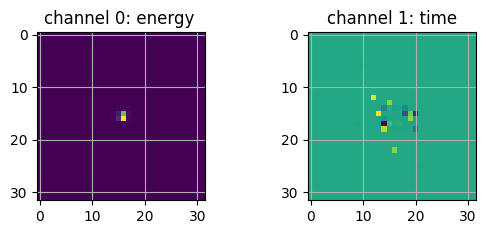

In [41]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("channel 0: energy ")
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("channel 1: time")
plt.grid(True)

plt.show()

In [43]:
width, height = 128, 128
batch_size = 16
epochs = 10

In [44]:
class Maxout(tf.keras.layers.Layer):
    def __init__(self, num_units=5):
        super(Maxout, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        self.fc = tf.keras.layers.Dense(input_shape[-1] * self.num_units)

    def call(self, x):
        out = self.fc(x)
        out = tf.reshape(out, [-1, x.shape[-1], self.num_units])
        out = tf.reduce_max(out, axis=2)
        return out

In [45]:
from keras.layers import Layer
import keras.backend as K

class LocalResponseNormalization(Layer):
    def __init__(self, alpha=1e-4, beta=0.75, k=2, **kwargs):
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LocalResponseNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x):
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.k, self.k), padding="same", pool_mode="avg")
        normalized = x / K.pow((self.alpha * pooled + 1.0), self.beta)
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape

In [63]:
# Define the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))

model.add(MaxPool2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(LocalResponseNormalization()) 
model.add(MaxPool2D(2, 2))


model.add(Flatten())
#model.add(Dense(256, activation=Maxout()))
#model.add(Dropout(0.2))
#model.add(Dense(128, activation=Maxout()))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(25, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


In [64]:
model.compile(loss = tf.keras.losses.binary_crossentropy, 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1.e-3), 
              metrics =[tf.keras.metrics.BinaryAccuracy(name = 'accuracy')]
             )

In [65]:
model.fit(X_train, y_train, batch_size = 32 , epochs = 10 , validation_data = (X_val , y_val ), verbose =2)

Epoch 1/10
720/720 - 8s - loss: 0.6744 - accuracy: 0.5701 - val_loss: 0.6591 - val_accuracy: 0.6094 - 8s/epoch - 11ms/step
Epoch 2/10
720/720 - 8s - loss: 0.6544 - accuracy: 0.6162 - val_loss: 0.6565 - val_accuracy: 0.6180 - 8s/epoch - 12ms/step
Epoch 3/10
720/720 - 8s - loss: 0.6438 - accuracy: 0.6308 - val_loss: 0.6563 - val_accuracy: 0.6059 - 8s/epoch - 12ms/step
Epoch 4/10
720/720 - 9s - loss: 0.6310 - accuracy: 0.6481 - val_loss: 0.6353 - val_accuracy: 0.6445 - 9s/epoch - 12ms/step
Epoch 5/10
720/720 - 8s - loss: 0.6152 - accuracy: 0.6688 - val_loss: 0.6231 - val_accuracy: 0.6539 - 8s/epoch - 12ms/step
Epoch 6/10
720/720 - 8s - loss: 0.6047 - accuracy: 0.6806 - val_loss: 0.6176 - val_accuracy: 0.6613 - 8s/epoch - 12ms/step
Epoch 7/10
720/720 - 8s - loss: 0.5962 - accuracy: 0.6869 - val_loss: 0.6200 - val_accuracy: 0.6625 - 8s/epoch - 12ms/step
Epoch 8/10
720/720 - 8s - loss: 0.5884 - accuracy: 0.6974 - val_loss: 0.6171 - val_accuracy: 0.6668 - 8s/epoch - 12ms/step
Epoch 9/10
720/7

200/200 [==============================] - 1s 7ms/step


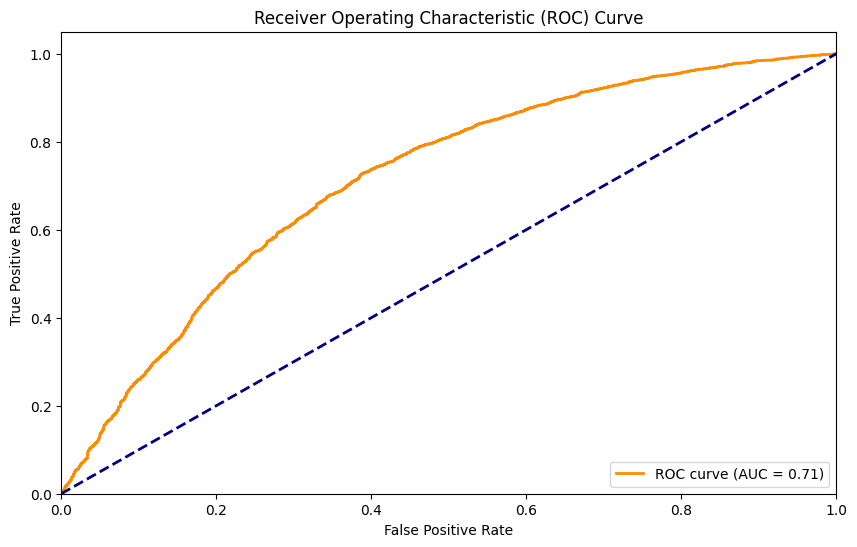

In [66]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have a trained Sequential model
y_pred = model.predict(X_test)  # Replace 'X_test' with your test data
y_pred_proba = y_pred.flatten()  # Flatten the predictions to obtain probabilities

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Replace 'y_true' with your true labels

# Calculate the AUC (Area Under the ROC Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Replace 'y_true' with your true labels

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

